In [12]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from wordcloud import WordCloud

# Загрузка данных

In [13]:
with open("by_repo_results.csv", "r", encoding='utf-8') as f:
  csvreader = csv.reader(f, delimiter=";")
  headers = next(csvreader)
  data = []
  for row in csvreader:
    if row[0].strip(): 
        company_name = row[0]
        company_description = row[1]
        data.append(row)
    else:
        row[0] = company_name
        row[1] = company_description
        data.append(row)

repo_df = pd.DataFrame(data=data, columns=headers).dropna().reset_index().drop('index', axis=1)

org_df = pd.read_csv("by_org_results.csv", delimiter=";").dropna().reset_index().drop('index', axis=1)


# Приведение типов

In [14]:
repo_df["repo_stars"] = repo_df["repo_stars"].astype(np.int32)
repo_df["repo_half_year_commits"] = repo_df["repo_half_year_commits"].astype(np.int32)

# преобразуем даты в datetime с временной зоной UTC
repo_df['repo_last_commit_date'] = pd.to_datetime(
    repo_df['repo_last_commit_date'],
    format='%Y-%m-%dT%H:%M:%SZ',
    errors='coerce',
    utc=True
)

org_df['stars_count'] = org_df['stars_count'].astype(np.int32)

# Количество репозиториев на компанию

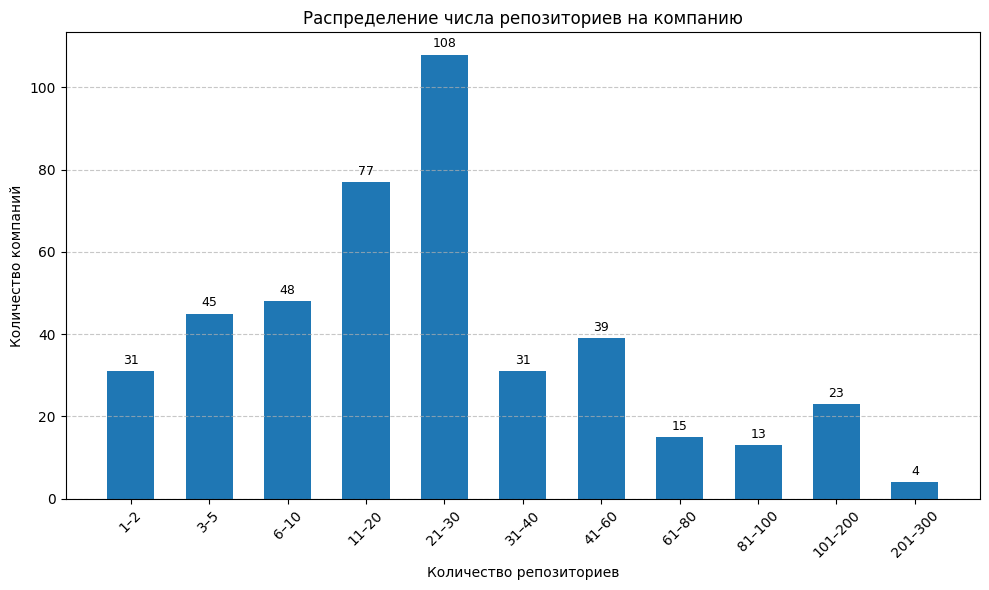

In [15]:
org_repo_counts = repo_df.groupby("organization")["repo_name"].count()

# Бины вручную
bins = [0, 2, 5, 10, 20, 30, 40, 60, 80, 100, 200, 300]
bin_labels = [f"{bins[i]+1}–{bins[i+1]}" for i in range(len(bins)-1)]
cut = pd.cut(org_repo_counts, bins=bins, labels=bin_labels, include_lowest=True)

# Группировка по бинам
grouped = cut.value_counts().sort_index()

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(grouped)), grouped.values, width=0.6)
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_title("Распределение числа репозиториев на компанию")
ax.set_xlabel("Количество репозиториев")
ax.set_ylabel("Количество компаний")

# Добавление подписей
for i, value in enumerate(grouped.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Группы компаний по звездам

C:\Users\Мария\AppData\Local\Temp\ipykernel_20184\3112009165.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = org_df.groupby(star_bins)["organization"].count()


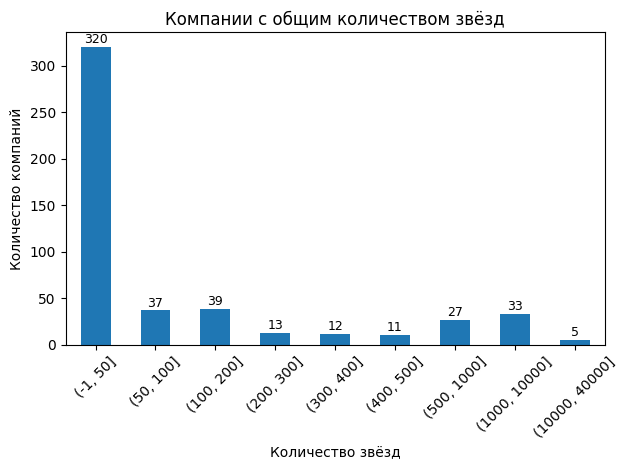

In [16]:
bins = [-1, 50, 100, 200, 300, 400, 500, 1000, 10000, 40000]

star_bins = pd.cut(org_df["stars_count"], bins=bins)

grouped = org_df.groupby(star_bins)["organization"].count()

ax = grouped.plot(kind="bar", rot=45, title="Компании с общим количеством звёзд")
plt.xlabel("Количество звёзд")
plt.ylabel("Количество компаний")

for i, value in enumerate(grouped):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


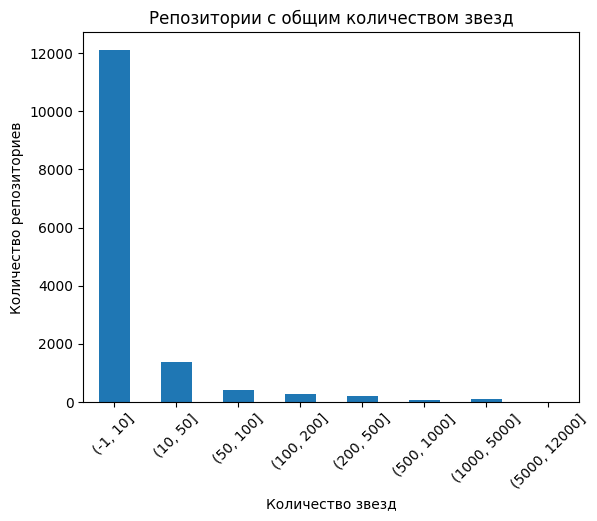

In [17]:
repo_df.groupby(pd.cut(repo_df["repo_stars"], [-1, 10, 50, 100, 200, 500, 1000, 5000, 12000]), observed=False).count()["repo_name"].plot(kind="bar", rot=45, title="Репозитории с общим количеством звезд")

plt.xlabel("Количество звезд")
plt.ylabel("Количество репозиториев")
None


# Топ-10 репозиториев по звездам

In [18]:
repo_df[["organization", "repo_name", "repo_stars"]].sort_values(by="repo_stars", ascending=False).head(n=10).reset_index()

,index,organization,repo_name,repo_stars
0,1038,apolloauto,apollo,25514
1,6565,nvidia,nvidia-docker,17326
2,6624,nvidia,DeepLearningExamples,13963
3,6679,nvidia,NeMo,13172
4,6656,nvidia,Megatron-LM,11464
5,6665,nvidia,TensorRT,11206
6,12610,apple,turicreate,11196
7,6615,nvidia,FastPhotoStyle,11166
8,12606,apple,darwin-xnu,11085
9,13025,autowarefoundation,autoware,9668


# Рейтинг языков программирования

leading_language
C++                 4533
Python              2591
C                   1375
JavaScript           702
CMake                495
                    ... 
Witcher Script         1
Xtend                  1
YARA                   1
Zig                    1
nesC                   1
Name: count, Length: 122, dtype: int64


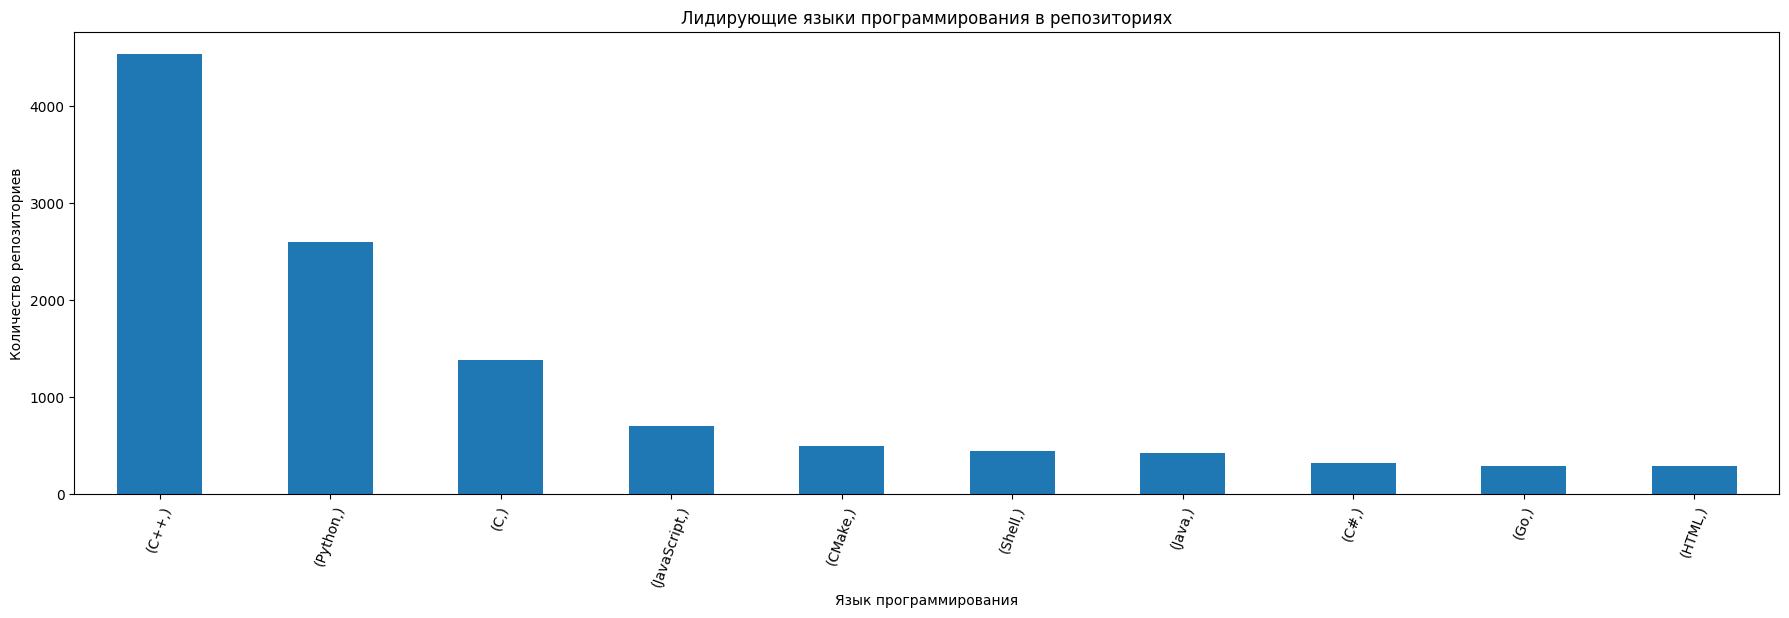

In [19]:
repo_df["leading_language"] = repo_df["repo_languages"].apply(lambda x: x[2:x.find(":")] if ":" in x else None)

repo_df[["leading_language"]].value_counts().head(10).plot.bar(rot=70, figsize=(22, 6), title="Лидирующие языки программирования в репозиториях")

plt.xlabel("Язык программирования")
plt.ylabel("Количество репозиториев")
None

print(repo_df[["leading_language"]].value_counts().sort_values(ascending=False))

Python        6575
C++           6216
CMake         6192
C             3933
Makefile      2512
JavaScript    1887
None          1341
Batchfile      917
Cuda           410
Tcl            128
dtype: int64


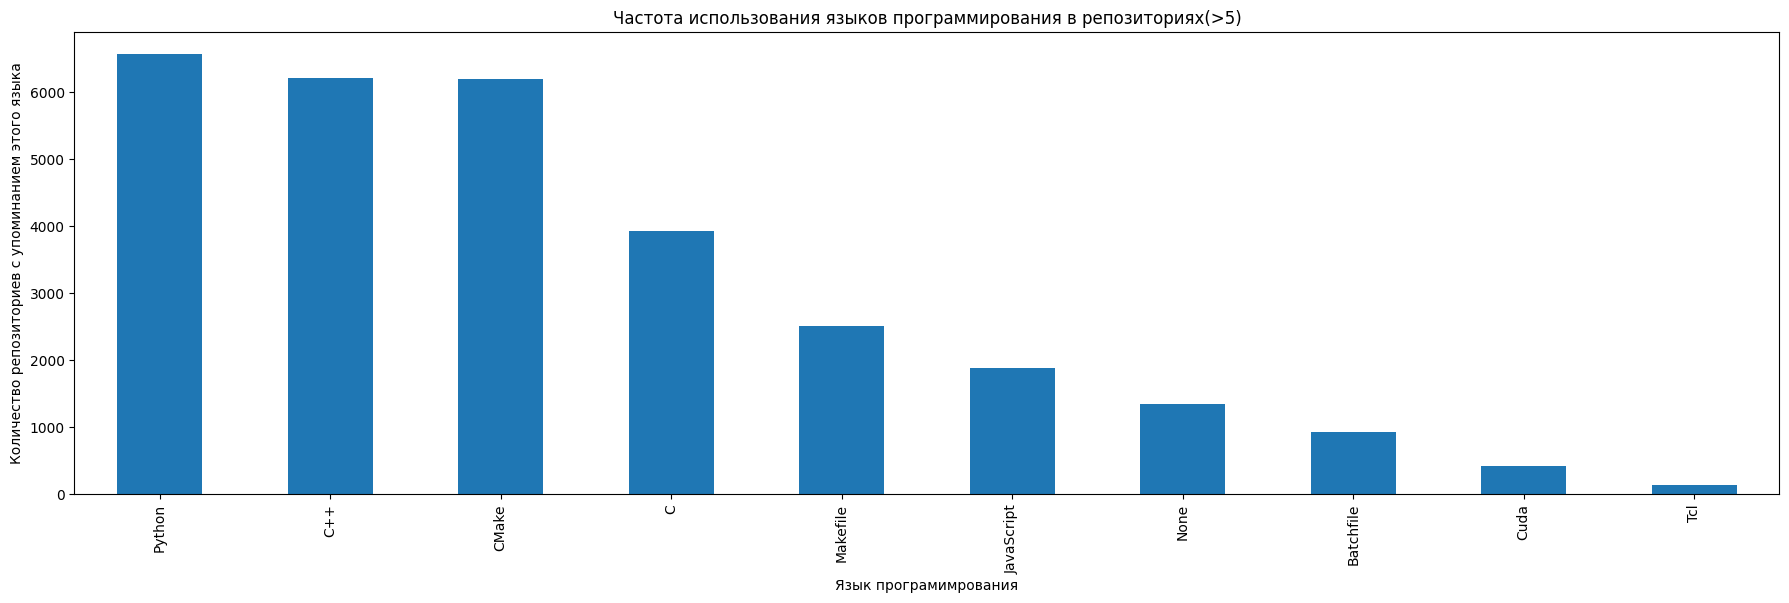

In [20]:
import collections

counter = collections.Counter([x for xs in [
    list(
        map(
            lambda x: x[:x.find(":")].strip() if ":" in x else None,
            s.replace("('", "").replace("',)", "").split(",")
            )
        ) for s in list(repo_df["repo_languages"])]
  for x in xs])

freq_series = pd.Series(dict(counter)).head(10)
freq_series[freq_series > 5].sort_values(ascending=False).plot.bar(figsize=(22, 6), title="Частота использования языков программирования в репозиториях(>5)")

plt.xlabel("Язык програмимрования")
plt.ylabel("Количество репозиториев с упоминанием этого языка")

print(freq_series[freq_series > 5].sort_values(ascending=False).head(10))

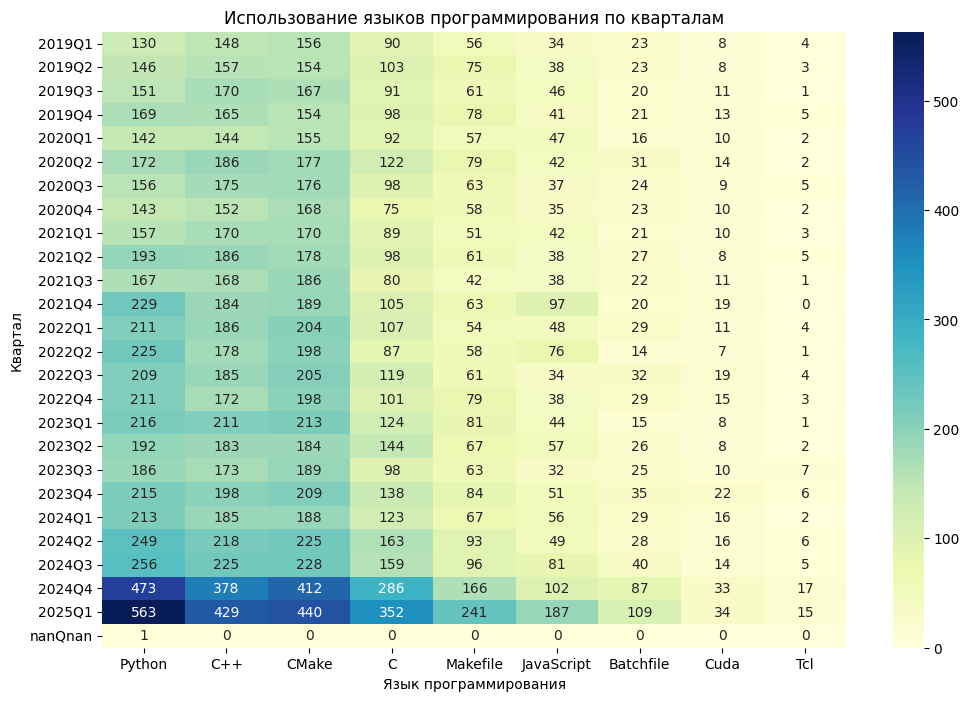

In [24]:
def group_by_quarter(date):
  if date.year < 2019: # Starting from 2019
    return 'Before Start Date'
  quarter = (date.month - 1) // 3 + 1
  year = date.year
  return f"{year}Q{quarter}"

repo_df['quarter'] = repo_df['repo_last_commit_date'].apply(group_by_quarter)

language_counts_by_quarter = {}

for quarter, group in repo_df.groupby('quarter'):
  if quarter != 'Before Start Date':
    language_counts = {}
    for languages in group['repo_languages']:
      for language in [
          x[:x.find(":")].strip() if ":" in x else None
          for x in languages.replace("('", "").replace("',)", "").split(",")
      ]:
        if language:
          if language not in language_counts:
            language_counts[language] = 0
          language_counts[language] += 1
    language_counts_by_quarter[quarter] = language_counts

language_counts_df = pd.DataFrame.from_dict(language_counts_by_quarter, orient='index')
language_counts_df = language_counts_df.fillna(0).sort_index()

top_languages = freq_series[freq_series > 5].sort_values(ascending=False).head(20) #
top_languages_list = top_languages.index.to_list()
if None in top_languages_list:
  top_languages_list.remove(None)
language_counts_df[top_languages_list]

plt.figure(figsize=(12, 8))
sns.heatmap(language_counts_df[top_languages_list], annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Использование языков программирования по кварталам")
plt.xlabel("Язык программирования")
plt.ylabel("Квартал")
plt.show()

# Облако тэгов

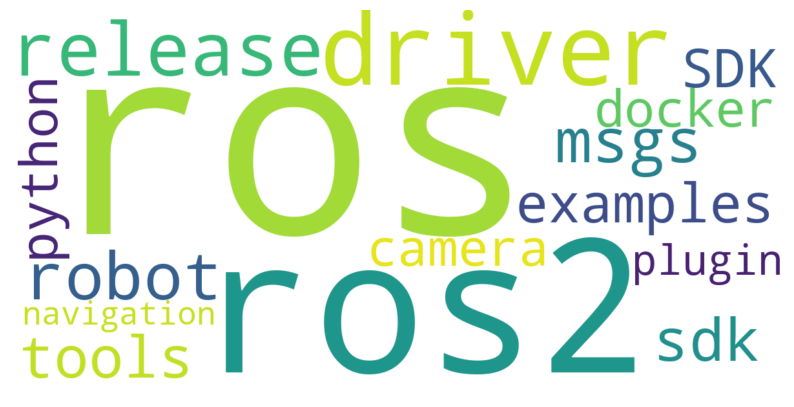

In [22]:
wc = WordCloud(
    background_color="white",
    max_words=20000,
    width=1200,
    height=600
)

words = [x for xs in [
    json.loads(x.replace("'", '"')) for x in list(org_df["name_parts"])]
  for x in xs]

dict_words = {}
for w in words:
  if w in dict_words:
      dict_words[w] += 1
  else:
      dict_words[w] = 1

filtered_dict = {k: dict_words[k] for k in dict_words.keys() if dict_words[k] >= 3}
limited_dict = {k: v for k, v in sorted(filtered_dict.items(), key=lambda item: item[1], reverse=True)[:15]}

# wc.generate(", ".join(filtered_words))
wc.fit_words(limited_dict)

plt.rcParams["figure.figsize"] = (10,6)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
None